In [1]:
import os
import numpy as np
import argparse
import json
import logging
import time
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Bernoulli

import torchvision
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter  # TensorBoard

import algorithms.vae.model as vae_model
from algorithms.vae.gridworld_dataset import GridworldDataset
from algorithms.vae.pong_dataset import PongDataset

import sys

In [302]:
parser = argparse.ArgumentParser(description='VAE MNIST')
parser.add_argument('-f')
parser.add_argument('--log_root', default='algorithms/runs/', help='directory to store logs')
parser.add_argument('--data_root', default='algorithms/data/', help='directory to store the dataset')
parser.add_argument('--dataset', default='mnist', help='dataset')
parser.add_argument('--batch_size', type=int, default=64, help='input batch size (default: 64)')
parser.add_argument('--epochs', type=int, default=10, help='number of epochs (default: 100)')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate (default: 1e-3)')
parser.add_argument('--latent_dim', type=int, default=10, help='latent dimension (default: 10)')
parser.add_argument('--beta', type=float, default=1, help='beta for beta-VAE (default: 1) = basic VAE')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
parser.add_argument('--log_interval', type=int, default=100, help='logging frequency measured by number of training episodes')
parser.add_argument('--no-cuda', action='store_true', default=False, help='enables CUDA')
parser.add_argument('--log_elbo', action='store_true', default=False, help='stores elbo for each input into log file')
parser.add_argument('--eval_set', type=str, default='not_in_training', help='name of the evaluation set')
parser.add_argument('--eval', action='store_true', default=False, help='run only evaluation')
parser.add_argument('--comment', default='', help='additional comment to the run')

args = parser.parse_args("""--epochs=150 --beta=0.1 --dataset=pong --log_interval=30 --latent_dim=10
                         --batch_size=32 --lr=0.0005 --comment='conv4_black-bg-no-line_train-test_batch-norm'
                         --data_root=/home/lukas/Workspaces/DTU/runs/dqn/pong/2019-17-12-12:49:14 """.split()
)

# if gpu is to be used
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

torch.manual_seed(args.seed)
np.random.seed(args.seed)

In [270]:
args.data_root

'/home/lukas/Workspaces/DTU/runs/dqn/pong/2019-17-12-12:49:14'

In [271]:
if args.dataset == 'pong':
	print(args.data_root)
# 	csv_file = f"{args.data_root}/state-action-catastrophe_labeled.csv"
# 	csv_file = f"{args.data_root}/testset.csv"
	csv_file = f"{args.data_root}/adversaryset.csv"
# 	images_dir = f"{args.data_root}/no-line-states-black-bg/"
# 	images_dir = f"{args.data_root}/test-set/"
# 	images_dir = f"{args.data_root}/adversary-set/big-ball/"
# 	images_dir = f"{args.data_root}/adversary-set/new-obstacle/"
# 	images_dir = f"{args.data_root}/adversary-set/oponent-moved/"
# 	images_dir = f"{args.data_root}/adversary-set/paddle-cross/"
	images_dir = f"{args.data_root}/adversary-set/too-high-too-low/"
	pong_dataset = PongDataset(csv_file=csv_file, images_dir=images_dir, transform=transforms.ToTensor(), classes=['none'])
	img_size = (80, 90)
	in_channels = 1
else:
	raise NotImplementedError

if args.dataset == 'pong':
	train_loader = torch.utils.data.DataLoader(dataset=pong_dataset, batch_size=args.batch_size, pin_memory=args.cuda, shuffle=True)
	test_loader = torch.utils.data.DataLoader(dataset=pong_dataset, batch_size=args.batch_size, pin_memory=args.cuda, shuffle=True)

/home/lukas/Workspaces/DTU/runs/dqn/pong/2019-17-12-12:49:14


In [272]:
# encoder = vae_model.MLPEncoderOne(args.latent_dim, img_size).to(device)
# decoder = vae_model.MLPDecoderOne(args.latent_dim, img_size).to(device)
# encoder = vae_model.MLPEncoder(args.latent_dim, img_size).to(device)
# decoder = vae_model.MLPDecoder(args.latent_dim, img_size).to(device)
encoder = vae_model.EncoderPong(args.latent_dim).to(device)
decoder = vae_model.DecoderPong(args.latent_dim).to(device)
# encoder = EncoderPong(args.latent_dim).to(device)
# decoder = DecoderPong(args.latent_dim).to(device)
# encoder = vae_model.Encoder(args.latent_dim).to(device)
# decoder = vae_model.Decoder(args.latent_dim).to(device)
vae = vae_model.VAE(encoder, decoder).to(device)

In [273]:
def test(epoch, test_loader):
	vae.eval()
	batch_loss = []
	epoch_elbos = []

	test_loss = 0.0
	with torch.no_grad():
		for i, (x, _) in enumerate(test_loader):
			x = x.to(device)
			out = vae(x)
			loss, kl, elbo_batch = loss_function(x=x, beta=args.beta, **out)
			batch_loss.append(loss.item())
			test_loss += loss.item()
			epoch_elbos.extend(elbo_batch.cpu().detach().numpy().flatten())  # store the elbo for each input datapoint into a list
# 			if i == 0 and not args.eval:
				# Record input images
# 				in_grid = torchvision.utils.make_grid(x.view(-1, in_channels, img_size[1], img_size[0]).cpu())
# 				valid_writer.add_image('input images', in_grid)

				# Record reconstructed images
# 				out_grid = torchvision.utils.make_grid(out['z_mu'].view(-1, in_channels, img_size[1], img_size[0]).cpu())
# 				valid_writer.add_image('reconstructions', out_grid)

	# test_loss /= len(test_loader.dataset)
	# print('====> Test set loss: {:.4f}'.format(test_loss))

	if args.log_elbo:
		epoch_elbos

	return np.mean(batch_loss), epoch_elbos


def save_model(model, log_dir):
    pth = os.path.join(log_dir, f"{args.dataset}_b{args.beta}_z{args.latent_dim}_ep{args.epochs}_model.pth")
    torch.save(model.state_dict(), pth)

def load_model(model, log_dir):
    model.load_state_dict(torch.load(
        os.path.join(log_dir, f"{args.dataset}_b{args.beta}_z{args.latent_dim}_ep{args.epochs}_model.pth"))
                         )

In [274]:
def ELBO_loss(x, z, q_zx, p_xz, p_z, beta, **kwargs):
	x = x.view(x.shape[0], -1)
	# print(x.shape)
	log_prob_p_xz = p_xz.log_prob(x).sum(dim=1)
	log_prob_p_z = p_z.log_prob(z).sum(dim=1)
	log_prob_q_zx = q_zx.log_prob(z).sum(dim=1)
	elbo_batch = log_prob_p_xz + beta*(log_prob_p_z - log_prob_q_zx)
	loss = -torch.mean(elbo_batch)
	kl = torch.mean(beta*(log_prob_p_z - log_prob_q_zx))
#     print(loss, torch.mean(log_prob_p_xz).item(), torch.mean(log_prob_p_z).item(), torch.mean(log_prob_q_zx).item())
	return loss, kl, elbo_batch


loss_function = ELBO_loss
optimizer = optim.Adam(vae.parameters(), lr=args.lr)

In [303]:
# load_model(vae, '/home/lukas/Workspaces/DTU/deep-rl-thesis/algorithms/runs/gridworld-10-epochs10-beta1-seed1-MLP-color-2019-15-12-16:27:20')
# load_model(vae, '/home/lukas/Workspaces/DTU/deep-rl-thesis/algorithms/trained_models/gridworld/7x7')
load_model(vae, '/home/lukas/Workspaces/DTU/deep-rl-thesis/algorithms/trained_models/pong/no-line-black-bg/beta0.1')
vae.eval()
_, epoch_elbos = test(0, test_loader)
"""
# print(epoch_elbos)
eval_logger = logging.getLogger(f'{args.dataset}_epochs{args.epochs}_beta{args.beta}_test - {args.eval_set}')
eval_logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler(f'eval_epoch_elbos.log')
fh.setLevel(logging.DEBUG)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
# add the handlers to the logger
eval_logger.addHandler(fh)
eval_logger.info(epoch_elbos)
"""

"\n# print(epoch_elbos)\neval_logger = logging.getLogger(f'{args.dataset}_epochs{args.epochs}_beta{args.beta}_test - {args.eval_set}')\neval_logger.setLevel(logging.DEBUG)\n# create file handler which logs even debug messages\nfh = logging.FileHandler(f'eval_epoch_elbos.log')\nfh.setLevel(logging.DEBUG)\n# create formatter and add it to the handlers\nformatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')\nfh.setFormatter(formatter)\n# add the handlers to the logger\neval_logger.addHandler(fh)\neval_logger.info(epoch_elbos)\n"

In [253]:
# beta1_big_ball_elbos = epoch_elbos
# beta1_new_obstacle_elbos = epoch_elbos
# beta1_oponent_moved_elbos = epoch_elbos
# beta1_paddle_cross_elbos = epoch_elbos
# beta1_too_high_too_low_elbos = epoch_elbos

In [20]:
for i, (x, _) in enumerate(test_loader):
    x = x.to(device)
    out = vae(x)
    loss, kl, elbo_batch = loss_function(x=x, beta=args.beta, **out)
    
    in_grid = torchvision.utils.make_grid(x.view(-1, in_channels, img_size[1], img_size[0]).cpu())
    break

In [51]:
x_train, _ = next(iter(train_loader))
x_train.shape

torch.Size([32, 1, 90, 80])

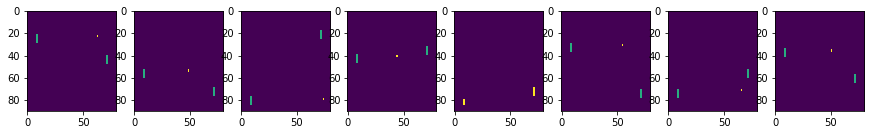

In [52]:
my_num = 0
# in_grid.shape
img = np.transpose(x_train[0], (1,2,0))
img.shape
fig, ax = plt.subplots(ncols=8, figsize=(15,5))
for i, x_i in enumerate(range(my_num*8, (my_num+1)*8)):
#     img = np.transpose(x_train[x_i], (1,2,0))
#     ax[i].imshow(img)
    ax[i].imshow(x_train[x_i][0])
plt.show()

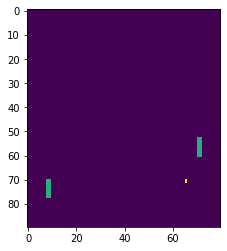

In [53]:
x1 = np.transpose(x_train[2], (1,2,0)) ##
x2 = np.transpose(x_train[6], (1,2,0)) ##
# a62_w04 = np.transpose(x_train[51], (1,2,0)) ###
# a03_w11 = np.transpose(x_train[56], (1,2,0)) #
# a03_w32 = np.transpose(x_train[33], (1,2,0)) #
# a03_w06 = np.transpose(x_train[37], (1,2,0)) #
# a03_w34 = np.transpose(x_train[51], (1,2,0)) #
# img = np.transpose(x_train[26], (1,2,0))
# plt.imshow(img)
plt.imshow(x_train[6][0])
plt.show()

# Test Interpolation

In [288]:
# out_recon['z_mu'].min()
# x_train[0]
# plt.imshow(np.transpose(x_train[0], (1,2,0)))
# img_base = '/home/lukas/Workspaces/DTU/deep-rl-thesis/algorithms/data/Gridworlds/moving_water/7x7/interpolation'
img_base = '/home/lukas/Workspaces/DTU/runs/dqn/pong/2019-17-12-12:49:14/no-line-states-black-bg'
img_1 = cv2.imread(img_base + '/0-14.png', 0)
img_2 = cv2.imread(img_base + '/0-400.png', 0)
img_3 = cv2.imread(img_base + '/0-23.png', 0)
img_4 = cv2.imread(img_base + '/0-125.png', 0)
transform = transforms.ToTensor()
x_1 = transform(img_1).to(device)
x_2 = transform(img_2).to(device)
x_3 = transform(img_3).to(device)
x_4 = transform(img_4).to(device)
plt.imshow(img_4)

In [304]:
print('beta=0')
vae.eval()
with torch.no_grad():
    x_in = x_4
    out_recon = vae(x_in.unsqueeze(0))
    in_grid = torchvision.utils.make_grid(x_in.view(-1, in_channels, img_size[1], img_size[0]).cpu())
    out_grid = torchvision.utils.make_grid(out_recon['z_mu'].view(-1, in_channels, img_size[1], img_size[0]).cpu())

fig, ax = plt.subplots(ncols=2, figsize=(15,8))
ax[0].imshow(np.transpose(in_grid, (1,2,0)))
ax[1].imshow(np.transpose(out_grid, (1,2,0)))
ax[0].axis('off')
ax[1].axis('off')
plt.show()

beta=0


In [292]:
def latent_interpolation(x_1, x_2, num=15):
    vae.eval()
    with torch.no_grad():
#         z_1_mu, z_1_logvar = vae.encoder(np.transpose(x_1, (2, 0, 1)).unsqueeze(0))
#         z_2_mu, z_2_logvar = vae.encoder(np.transpose(x_2, (2, 0, 1)).unsqueeze(0))
        z_1_mu, z_1_logvar = vae.encoder(x_1.unsqueeze(0))
        z_2_mu, z_2_logvar = vae.encoder(x_2.unsqueeze(0))
        z_linspace = np.linspace(z_1_mu, z_2_mu, num=num)
        interpolation_recon = vae.decoder(torch.from_numpy(z_linspace).squeeze(1).to(device))
        
    out_grid = torchvision.utils.make_grid(interpolation_recon, pad_value=0.6, nrow=10)
    fig, ax = plt.subplots(1, figsize=(20,5))
    ax.imshow(np.transpose(out_grid, (1,2,0)))
    ax.axis('off')
    fig.show()
    return z_linspace

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


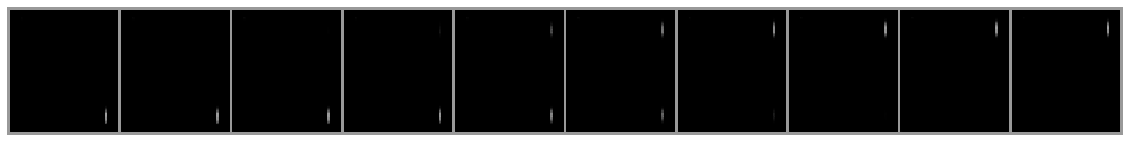

In [295]:
linspace = latent_interpolation(x_1, x_2, num=10)

In [300]:
linspace = latent_interpolation(x_1, x_2, num=10)

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [305]:
linspace = latent_interpolation(x_1, x_2, num=10)

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


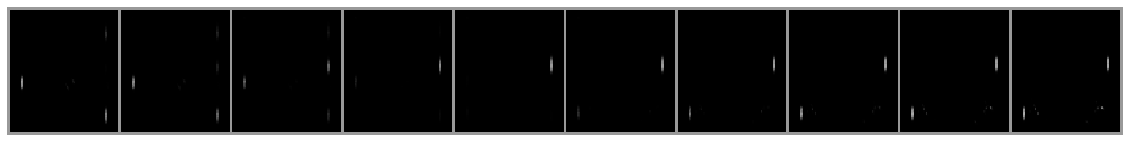

In [296]:
linspace = latent_interpolation(x_3, x_4, num=10)

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


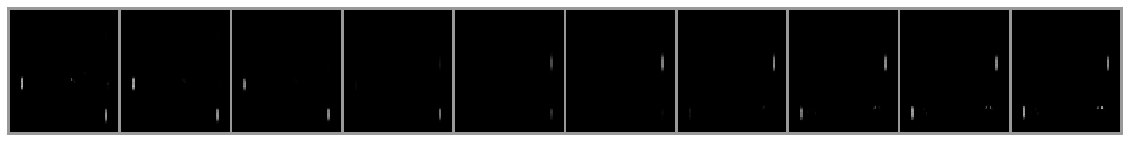

In [301]:
linspace = latent_interpolation(x_3, x_4, num=10)

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


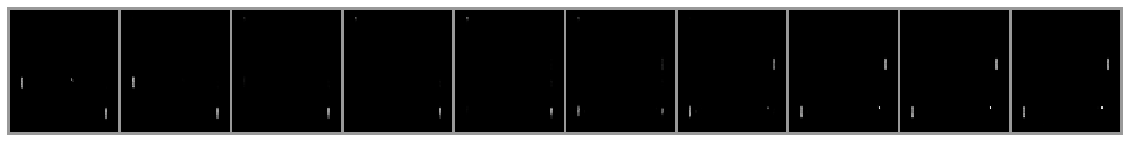

In [306]:
linspace = latent_interpolation(x_3, x_4, num=10)

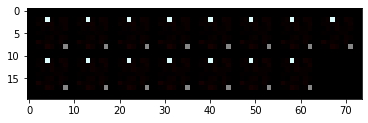

In [164]:
# fig, ax = plt.subplots(ncols=15, figsize=(20,5))
# for i in range(15):
#     img = np.transpose(w30_w35_recon_out[i], (1,2,0))
#     ax[i].imshow(img)
out_grid = torchvision.utils.make_grid(w30_w35_recon_out)
plt.imshow(np.transpose(out_grid, (1,2,0)))
plt.show()
# w30_w35_recon_out.shape

In [154]:
# Record latent space interpolations
n = 15
with torch.no_grad():
    latent_space = torch.zeros((n*args.latent_dim, args.latent_dim))
    for i in range(args.latent_dim):
        latent_space[i*n:(i+1)*n, i] = torch.from_numpy(np.linspace(-3, 3, n))
    # print(latent_space)
#     recon_out = vae.decoder(latent_space.to(device))
#     grid = torchvision.utils.make_grid(recon_out.view(-1, in_channels, img_size[1], img_size[0]).cpu(), nrow=n)
latent_space.shape

torch.Size([150, 10])

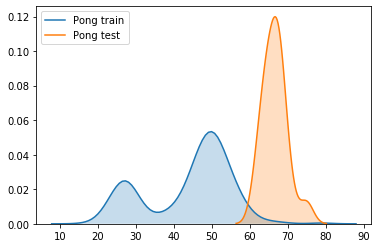

In [88]:
# beta2
import seaborn as sns
sns.kdeplot(-np.array(beta2_train_elbos), shade=True, label='Pong train')
sns.kdeplot(-np.array(beta2_test_elbos), shade=True, label='Pong test')
# epoch_elbos

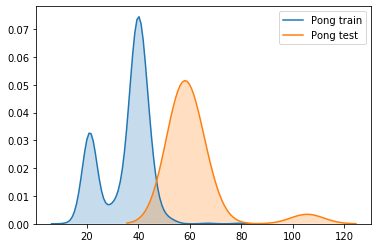

In [112]:
# beta1
import seaborn as sns
sns.kdeplot(-np.array(beta1_train_elbos), shade=True, label='Pong train')
sns.kdeplot(-np.array(beta1_test_elbos), shade=True, label='Pong test')

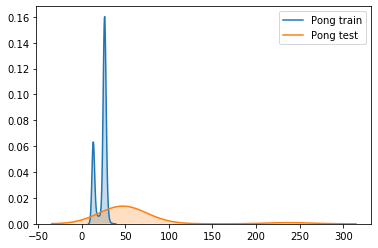

In [127]:
# beta0.1
import seaborn as sns
sns.kdeplot(-np.array(beta01_train_elbos), shade=True, label='Pong train')
# sns.kdeplot(-np.array(beta01_test_elbos), shade=True, label='Pong test')
b = [e for e in beta01_test_elbos if e > -10000]
sns.kdeplot(-np.array(b), shade=True, label='Pong test')

In [130]:
import pandas as pd
a = np.array(beta01_train_elbos)
b = np.full_like(a, np.nan)
for i, e in enumerate(beta01_test_elbos):
    if e > -10000:
        b[i] = e
df = pd.DataFrame({
    'pong_train': a,
    'pong_test': b
})

f, ax = plt.subplots(figsize=(7, 6))
# ax.set_yscale("log")
ax.set_ylabel('-log p(x)')
sns.boxplot(data=-df)

In [118]:
beta01_test_elbos

[-45.411575,
 -59.880295,
 -48.56442,
 -46.355553,
 -44.83179,
 -43.866703,
 -47.571724,
 -45.94013,
 -291456540.0,
 -45.396492,
 -48.284374,
 -237.5585,
 -45.002144,
 -43.040714,
 -42.700897,
 -73.07875,
 -43.2351,
 -43.03161]

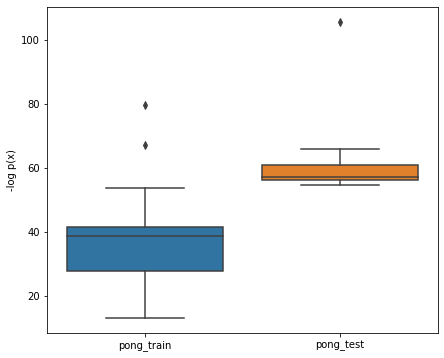

In [129]:
import pandas as pd
a = np.array(beta1_train_elbos)
b = np.full_like(a, np.nan)
for i, e in enumerate(beta1_test_elbos):
    b[i] = e
df = pd.DataFrame({
    'pong_train': a,
    'pong_test': b
})

f, ax = plt.subplots(figsize=(7, 6))
# ax.set_yscale("log")
ax.set_ylabel('-log p(x)')
sns.boxplot(data=-df)

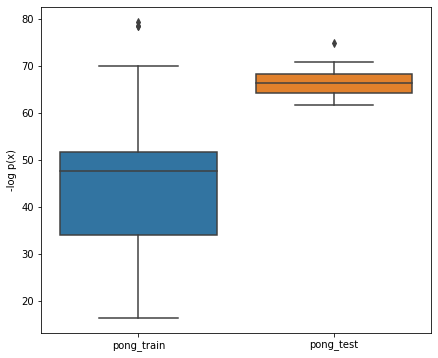

In [131]:
import pandas as pd
a = np.array(beta2_train_elbos)
b = np.full_like(a, np.nan)
for i, e in enumerate(beta2_test_elbos):
    b[i] = e
df = pd.DataFrame({
    'pong_train': a,
    'pong_test': b
})

f, ax = plt.subplots(figsize=(7, 6))
# ax.set_yscale("log")
ax.set_ylabel('-log p(x)')
sns.boxplot(data=-df)

# Beta = 2

In [262]:
import pandas as pd
a = np.array(beta2_train_elbos)
b = np.full_like(a, np.nan)
bb = np.full_like(a, np.nan)
no = np.full_like(a, np.nan)
om = np.full_like(a, np.nan)
pc = np.full_like(a, np.nan)
thtl = np.full_like(a, np.nan)
for i, e in enumerate(beta2_test_elbos): b[i] = e
for i, e in enumerate(beta2_big_ball_elbos):
    if e > -10000:
        bb[i] = e
for i, e in enumerate(beta2_new_obstacle_elbos): no[i] = e
for i, e in enumerate(beta2_oponent_moved_elbos):
    if e > -10000:
        om[i] = e
for i, e in enumerate(beta2_paddle_cross_elbos): pc[i] = e
for i, e in enumerate(beta2_too_high_too_low_elbos): thtl[i] = e
df = pd.DataFrame({
    'pong_train': a,
    'pong_test': b,
    'too_high_too_low': thtl,
    'paddle_cross': pc,
    'new_obstacle': no,
    'big_ball': bb,
    'oponent_moved': om,
})

f, ax = plt.subplots(figsize=(10, 10))
ax.set_yscale("log")
ax.set_ylabel('-log p(x)')
sns.boxplot(data=-df)

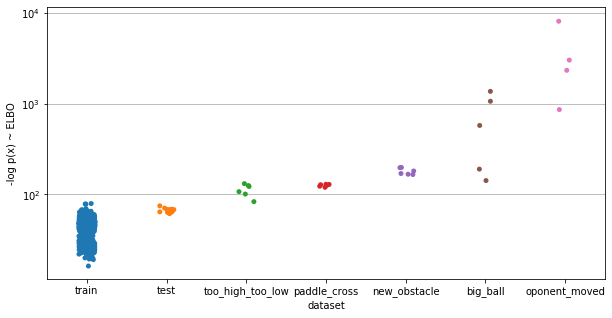

In [268]:
df = pd.DataFrame({
    'train': pd.DataFrame({'elbo': a}).elbo,
    'test': pd.DataFrame({'elbo': b}).elbo,
    'too_high_too_low': pd.DataFrame({'elbo': thtl}).elbo,
    'paddle_cross': pd.DataFrame({'elbo': pc}).elbo,
    'new_obstacle': pd.DataFrame({'elbo': no}).elbo,
    'big_ball': pd.DataFrame({'elbo': bb}).elbo,
    'oponent_moved': pd.DataFrame({'elbo': om}).elbo,
})
fig, ax = plt.subplots(figsize=(10,5))
ax.grid()
ax.set_yscale("symlog")
# ax.set_ylim(bottom=10)
ax.set_ylabel('-log p(x) ~ ELBO')
ax.set_xlabel('dataset')
# ax.set_title('VAE (beta=2) with 10 latent dimensions evaluated on pong datasets')
sns.stripplot(data=-df)

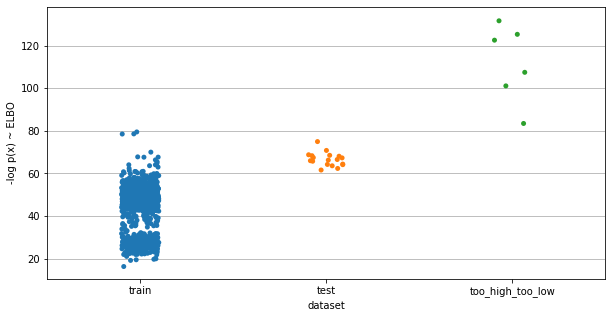

In [264]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid()
# ax.set_yscale("symlog")
# ax.set_ylim(bottom=10)
ax.set_ylabel('-log p(x) ~ ELBO')
ax.set_xlabel('dataset')
# ax.set_title('VAE (beta=2) with 10 latent dimensions evaluated on pong datasets')
sns.stripplot(data=-df[['train', 'test', 'too_high_too_low']])

# Beta = 1

In [230]:
a = np.array(beta1_train_elbos)
b = np.full_like(a, np.nan)
bb = np.full_like(a, np.nan)
no = np.full_like(a, np.nan)
om = np.full_like(a, np.nan)
pc = np.full_like(a, np.nan)
thtl = np.full_like(a, np.nan)
for i, e in enumerate(beta1_test_elbos): b[i] = e
for i, e in enumerate(beta1_big_ball_elbos):
    if e > -10000:
        bb[i] = e
for i, e in enumerate(beta1_new_obstacle_elbos): no[i] = e
for i, e in enumerate(beta1_oponent_moved_elbos):
    if e > -10000:
        om[i] = e
for i, e in enumerate(beta1_paddle_cross_elbos): pc[i] = e
for i, e in enumerate(beta1_too_high_too_low_elbos): thtl[i] = e

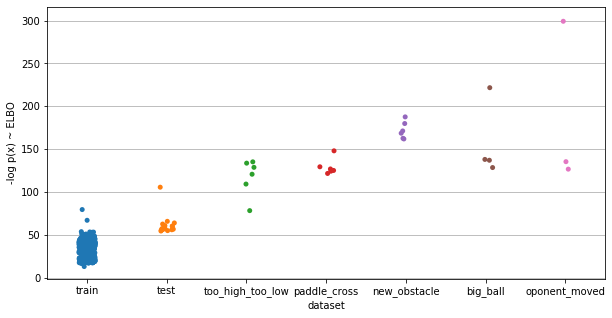

In [261]:
df = pd.DataFrame({
    'train': pd.DataFrame({'elbo': a}).elbo,
    'test': pd.DataFrame({'elbo': b}).elbo,
    'too_high_too_low': pd.DataFrame({'elbo': thtl}).elbo,
    'paddle_cross': pd.DataFrame({'elbo': pc}).elbo,
    'new_obstacle': pd.DataFrame({'elbo': no}).elbo,
    'big_ball': pd.DataFrame({'elbo': bb}).elbo,
    'oponent_moved': pd.DataFrame({'elbo': om}).elbo,
})
fig, ax = plt.subplots(figsize=(10,5))
ax.grid()
# ax.set_yscale("log")
# ax.set_ylim(bottom=10)
ax.set_ylabel('-log p(x) ~ ELBO')
ax.set_xlabel('dataset')
# ax.set_title('VAE (beta=1) with 10 latent dimensions evaluated on pong datasets')
sns.stripplot(data=-df)

# Beta = 0.1

In [256]:
a01 = np.array(beta01_train_elbos)
b01 = np.full_like(a01, np.nan)
bb01 = np.full_like(a01, np.nan)
no01 = np.full_like(a01, np.nan)
om01 = np.full_like(a01, np.nan)
pc01 = np.full_like(a01, np.nan)
thtl01 = np.full_like(a01, np.nan)
for i, e in enumerate(beta01_test_elbos): b01[i] = e
for i, e in enumerate(beta01_big_ball_elbos):
    if e > -10000:
        bb01[i] = e
for i, e in enumerate(beta01_new_obstacle_elbos):
    if e > -10000:
        no01[i] = e
for i, e in enumerate(beta01_oponent_moved_elbos):
    if e > -10000:
        om01[i] = e
for i, e in enumerate(beta01_paddle_cross_elbos): pc01[i] = e
for i, e in enumerate(beta01_too_high_too_low_elbos): thtl01[i] = e

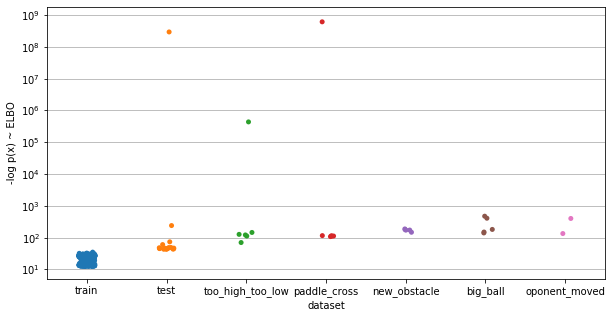

In [260]:
df01 = pd.DataFrame({
    'train': pd.DataFrame({'elbo': a01}).elbo,
    'test': pd.DataFrame({'elbo': b01}).elbo,
    'too_high_too_low': pd.DataFrame({'elbo': thtl01}).elbo,
    'paddle_cross': pd.DataFrame({'elbo': pc01}).elbo,
    'new_obstacle': pd.DataFrame({'elbo': no01}).elbo,
    'big_ball': pd.DataFrame({'elbo': bb01}).elbo,
    'oponent_moved': pd.DataFrame({'elbo': om01}).elbo,
})
fig, ax = plt.subplots(figsize=(10,5))
ax.grid()
ax.set_yscale("symlog")
# ax.set_ylim(bottom=10)
ax.set_ylabel('-log p(x) ~ ELBO')
ax.set_xlabel('dataset')
# ax.set_title('VAE (beta=0.1) with 10 latent dimensions evaluated on pong datasets')
sns.stripplot(data=-df01)